In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import pickle

## Data Preparation

In [2]:
df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED.csv')

In [3]:
df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,cleaned_barang_bukti,summarized_dakwaan,extracted_pasal,terdakwa,total_pidana_penjara_bulan
0,0,0,0,6,1 buah sabit kecil dengan gagang dari kayu 1 b...,Terdakwa Gede Darmayasa didakwa telah melakuka...,['Pasal 362 KUHP jo. Pasal 65 Ayat (1) KUHP'],GEDE DARMAYASA,5.0
1,1,1,1,4,1 lembar nota pembelian perhiasan kalung emas ...,"Pada bulan Februari dan Maret 2024, terdakwa I...","['Pasal 372 jo. 64 Ayat (1) KUHP', 'Pasal 378 ...",IDA BAGUS MADE DARMA WIGUNA,24.0
2,0,0,2,6,1 buah Kotak/Box handphone merk OPPO type A53 ...,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",['Pasal 363 Ayat (1) ke-3 KUHP'],HANDRI JOHANAS,4.0
3,2,2,1,2,1 buah plastik klip bening yang berisi kristal...,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",['Pasal 112 Ayat (1) UU RI No. 35 Tahun 2009 t...,I GEDE ARIADI alias BERNAD,14.0
4,2,3,1,2,1 buah plastik klip bening yang berisi kristal...,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",['Pasal 112 Ayat (1) UU RI No. 35 Tahun 2009 t...,I GEDE ARIADI alias BERNAD,14.0
...,...,...,...,...,...,...,...,...,...
4577,2,373,134,2,1 buah kotak hitam di dalamnya ada 1 plastik k...,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",['Pasal 114 Ayat (1) UU RI No. 35 Tahun 2009 T...,NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,72.0
4578,0,387,123,2,1 unit Handphone Samsung A52 Dikembalikan kepa...,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",['Pasal 363 Ayat (1) ke-4 KUHP'],SUPRIADI BIN RATIM,16.0
4579,0,389,123,2,1 unit Handphone Samsung A52 Dikembalikan kepa...,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",['Pasal 363 Ayat (1) ke-4 KUHP'],SUPRIADI BIN RATIM,16.0
4580,0,387,123,2,1 unit Handphone Samsung A52 Dikembalikan kepa...,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",['Pasal 363 Ayat (1) ke-4 KUHP'],ANWAR RURI BIN SYARIFUDIN USMAN,16.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4582 entries, 0 to 4581
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   klasifikasi_perkara_encoded  4582 non-null   int64  
 1   penuntut_umum_encoded        4582 non-null   int64  
 2   hakim_encoded                4582 non-null   int64  
 3   jumlah_saksi                 4582 non-null   int64  
 4   cleaned_barang_bukti         4582 non-null   object 
 5   summarized_dakwaan           4582 non-null   object 
 6   extracted_pasal              4582 non-null   object 
 7   terdakwa                     4582 non-null   object 
 8   total_pidana_penjara_bulan   4582 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 322.3+ KB


In [5]:
df_filtered = df.drop(columns=['extracted_pasal'])

### Split Data

In [6]:
def stratified_split(df: pd.DataFrame, split_size: float = 0.7) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()
    
    print(unique_groups)
    train_idx, test_idx = [], []
    
    for indices in unique_groups.values():        
        if len(indices) == 1:
            train_idx.extend(indices)
        else:
            train, test = train_test_split(indices, train_size=split_size, random_state=42)
            train_idx.extend(train)
            test_idx.extend(test)
    
    return df.loc[train_idx], df.loc[test_idx]

In [7]:
train_df, test_df = stratified_split(df_filtered)

{(0, 0, 0): [0, 20], (0, 0, 2): [2], (0, 1, 0): [19], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 13, 0): [32], (0, 13, 3): [34], (0, 15, 4): [33], (0, 16, 0): [37], (0, 17, 0): [38], (0, 17, 14): [440, 504, 598, 612], (0, 17, 16): [425], (0, 17, 18): [477, 668], (0, 17, 19): [787, 788, 789, 790], (0, 17, 20): [435, 441, 521, 581, 611, 728, 749], (0, 17, 21): [642, 826], (0, 18, 0): [39], (0, 19, 0): [40, 41], (0, 20, 0): [42], (0, 22, 7): [46], (0, 26, 10): [52, 54], (0, 27, 10): [137, 153, 173], (0, 27, 11): [75, 104], (0, 27, 12): [174], (0, 27, 14): [119], (0, 28, 10): [100, 148], (0, 28, 11): [55], (0, 29, 10): [56], (0, 30, 10): [57, 94], (0, 30, 12): [90], (0, 31, 9): [58], (0, 31, 10): [106, 107, 109], (0, 31, 12): [96, 97], (0, 32, 10): [59, 60, 61], (0, 32, 12): [101, 102], (0, 33, 10): [175], (0, 33, 14): [145, 163, 164, 165, 167, 178], (0, 34, 10): [63, 91, 92, 93], (0, 34, 11): [6

C:\Users\Kalea\AppData\Local\Temp\ipykernel_31504\1615946564.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()


In [8]:
jenis_klasifikasi_perkara = train_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Train:  {len(train_df)}")

klasifikasi_perkara_values = train_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Train:  3297
klasifikasi_perkara_encoded
0    1348
2    1280
3     300
4     188
1     181
Name: count, dtype: int64


In [9]:
jenis_klasifikasi_perkara = test_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Test:  {len(test_df)}")

klasifikasi_perkara_values = test_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Test:  1285
klasifikasi_perkara_encoded
0    631
2    522
4     62
3     48
1     22
Name: count, dtype: int64


In [10]:
df_filtered

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,cleaned_barang_bukti,summarized_dakwaan,terdakwa,total_pidana_penjara_bulan
0,0,0,0,6,1 buah sabit kecil dengan gagang dari kayu 1 b...,Terdakwa Gede Darmayasa didakwa telah melakuka...,GEDE DARMAYASA,5.0
1,1,1,1,4,1 lembar nota pembelian perhiasan kalung emas ...,"Pada bulan Februari dan Maret 2024, terdakwa I...",IDA BAGUS MADE DARMA WIGUNA,24.0
2,0,0,2,6,1 buah Kotak/Box handphone merk OPPO type A53 ...,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",HANDRI JOHANAS,4.0
3,2,2,1,2,1 buah plastik klip bening yang berisi kristal...,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",I GEDE ARIADI alias BERNAD,14.0
4,2,3,1,2,1 buah plastik klip bening yang berisi kristal...,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",I GEDE ARIADI alias BERNAD,14.0
...,...,...,...,...,...,...,...,...
4577,2,373,134,2,1 buah kotak hitam di dalamnya ada 1 plastik k...,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,72.0
4578,0,387,123,2,1 unit Handphone Samsung A52 Dikembalikan kepa...,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",SUPRIADI BIN RATIM,16.0
4579,0,389,123,2,1 unit Handphone Samsung A52 Dikembalikan kepa...,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",SUPRIADI BIN RATIM,16.0
4580,0,387,123,2,1 unit Handphone Samsung A52 Dikembalikan kepa...,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",ANWAR RURI BIN SYARIFUDIN USMAN,16.0


## Model

### Model Preprocessing

In [11]:
train_df['concat_text'] = train_df[['cleaned_barang_bukti', 'summarized_dakwaan', 'terdakwa']].apply(lambda x: ' '.join(x), axis=1)
test_df['concat_text'] = test_df[['cleaned_barang_bukti', 'summarized_dakwaan', 'terdakwa']].apply(lambda x: ' '.join(x), axis=1)

In [12]:
y_train = train_df['total_pidana_penjara_bulan']
y_test = test_df['total_pidana_penjara_bulan']

### Normalisasi

In [13]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['normalized_text'] = train_df['concat_text'].apply(normalize_text)
test_df['normalized_text'] = test_df['concat_text'].apply(normalize_text)

### Stopwords Removal

In [14]:
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

train_df['stopword_removal'] = train_df['normalized_text'].apply(remove_stopwords)
test_df['stopword_removal'] = test_df['normalized_text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kalea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Stemming

In [15]:
stemmer = PorterStemmer()

def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

train_df['stemmed_text'] = train_df['stopword_removal'].apply(stem_text)
test_df['stemmed_text'] = test_df['stopword_removal'].apply(stem_text)

### Tokenizer

In [16]:
# Tokenisasi
tokenizer = tf.keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(train_df['stemmed_text'])
train_sequences = tokenizer.texts_to_sequences(train_df['stemmed_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['stemmed_text'])

In [17]:
# Padding
max_len = max(len(seq) for seq in train_sequences)
X_train_texts = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_test_texts = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post')

In [18]:
print(max_len)

5035


### Numerical Features

In [20]:
train_numerical = tf.constant(train_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi']].values, dtype=tf.float32)
test_numerical = tf.constant(test_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi']].values, dtype=tf.float32)

### Model Architecture

In [21]:
text_input = tf.keras.layers.Input(shape=(max_len,), name='text_input')
embedding_layer = tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(text_input)
lstm_output = tf.keras.layers.LSTM(16, return_sequences=True)(embedding_layer)
lstm_output_2 = tf.keras.layers.LSTM(32, return_sequences=True)(lstm_output)
lstm_output_3 = tf.keras.layers.LSTM(64)(lstm_output_2)  # Shape (None, 64)

numerical_input = tf.keras.layers.Input(shape=(train_numerical.shape[1],), name='numerical_input')
numerical_dense = tf.keras.layers.Dense(32, activation='relu')(numerical_input)
numerical_dense_2 = tf.keras.layers.Dense(16, activation='relu')(numerical_dense)  # Shape (None, 16)

combined = tf.keras.layers.Concatenate()([lstm_output_3, numerical_dense_2])

output = tf.keras.layers.Dense(1, activation='linear')(combined)

In [22]:
model = tf.keras.Model(inputs=[text_input, numerical_input], outputs=output)

model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mean_absolute_error', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 5035)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5035, 128)    2709376     ['text_input[0][0]']             
                                                                                                  
 lstm (LSTM)                    (None, 5035, 16)     9280        ['embedding[0][0]']              
                                                                                                  
 numerical_input (InputLayer)   [(None, 4)]          0           []                               
                                                                                              

In [23]:
history = model.fit([X_train_texts, train_numerical], y_train, epochs=15, batch_size=32, validation_data=([X_test_texts, test_numerical], y_test))

Epoch 1/15
104/104 [==============================] - 70s 624ms/step - loss: 1453.3772 - mean_absolute_error: 29.4548 - root_mean_squared_error: 38.1232 - val_loss: 1364.2179 - val_mean_absolute_error: 26.6116 - val_root_mean_squared_error: 36.9353
Epoch 2/15
104/104 [==============================] - 77s 741ms/step - loss: 1047.4143 - mean_absolute_error: 26.6142 - root_mean_squared_error: 32.3638 - val_loss: 1356.4364 - val_mean_absolute_error: 26.4738 - val_root_mean_squared_error: 36.8298
Epoch 3/15
104/104 [==============================] - 64s 616ms/step - loss: 1051.1069 - mean_absolute_error: 26.8677 - root_mean_squared_error: 32.4208 - val_loss: 1345.8748 - val_mean_absolute_error: 26.8003 - val_root_mean_squared_error: 36.6862
Epoch 4/15
104/104 [==============================] - 64s 613ms/step - loss: 1026.3273 - mean_absolute_error: 26.4872 - root_mean_squared_error: 32.0363 - val_loss: 1333.8531 - val_mean_absolute_error: 26.2844 - val_root_mean_squared_error: 36.5220
Epoc

In [24]:
loss = model.evaluate([X_test_texts, test_numerical], y_test)
print(f'Model Loss: {loss}')

41/41 [==============================] - 11s 266ms/step - loss: 1215.2369 - mean_absolute_error: 24.3637 - root_mean_squared_error: 34.8602
Model Loss: [1215.2369384765625, 24.363666534423828, 34.86024856567383]


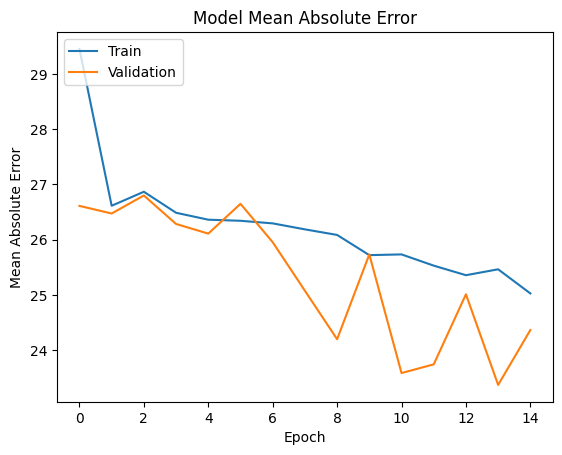

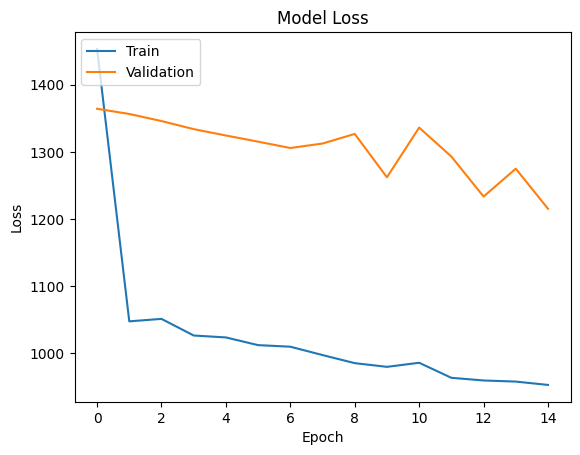

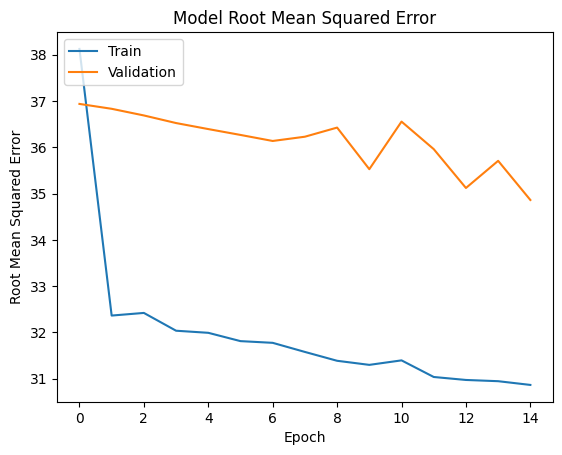

In [25]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Root Mean Squared Error')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Inference

In [25]:
klasifikasi_perkara_encoded = 0
penuntut_umum_encoded = 0
hakim_encoded = 7
jumlah_saksi_inference = 6
maks_penjara_berdasarkan_pasal = 84

inference_text = ["buah sabit gagang kayu buah jare plastik paranet warna hitam uta tali plastik warna biru meter puluh buah kantong plastik kresek uta tali kain warna merah cm dimusnahkan unit mobil merek suzuki st pick up warna hitam dk kc noka mhyesljj nosin gaid beserta kunci kontak lembar stnk mobil merek suzuki st pick up warna hitam dk kc noka mhyesljj nosin gaid nama pemilik an i kadek kondrayasa dikembalikan i gede agu wirayuda buah durian jeni durian kane dikembalikan i wayan sukaren lembar nota pembelian buah durian toko tiara durian dikembalikan komang ayu anggreni bela buah durian jeni durian kane lembar nota pembelian buah durian toko semut durian dikembalikan komang sujana uang tunai rp ratu delapan puluh tujuh ribu rupiah dirampa negara membebankan terdakwa membayar biaya perkara rp ribu rupiah terdakwa gede darmayasa selasa tanggal mei sekira jam wita selasa tanggal mei sekira jam wita sabtu tanggal mei sekira jam wita setidaktidaknya mei setidaktidaknya kebun milik i wayan sukerena banjar desa bunutin kecamatan kintamani kab bangli kebun milik i nyoman susila banjar desa bunutin kecamatan kintamani kab bangli kebun milik i ketut tindih banjar desa pengejaran kecamatan kintamani kab bangli setidaktidaknya daerah hukum pengadilan negeri bangli perbuatan dipandang perbuatan berdiri kejahatan mengambil barang kepunyaan orang maksud dimiliki melawan hukum terdakwa caracara selasa tanggal mei sekira wita terdakwa berangkat rumah terdakwa br dina pudeh ds tajun kec kubutambahan kab buleleng mobil suzuki carri pick up warna hitam dk kc pergi brd bunutin kec kintamani kab bangli melewati simpang pasar tenten kintamani tujuan memb menawarkan buah durian dipohonnya sesampainya terdakwa brd bunutin kec kintamani kab bangli sekira wita terdakwa pohon durian berbuah kebun milik i wayan sukerena dipinggir jalan raya ds bunutin kec kintamani kab bangli situasi sepi terdakwa melihatlihat buah durian menemukan buah dipetik terdakwa memetik buah durian memanjat pohon durian sabit memotong buah durian pohon bergiliran buah durian terdakwa petik puluh tujuh buahsetelah terkumpul buah durian terdakwa naikan mobil suzuki carri pick up warna hitam dk kc terdakwa kendarai buah durian diata mobil terdakwa meninggalkan kebun milik i wayan sukerena perjalanan terdakwa dipinggir jalan raya ds bunutin kintamani pohon durian berbuah terdakwa turun memarkir mobil suzuki carri pick up warna hitam dk kc dipinggir jalan raya berjalan kaki terdakwa kebun milik i nyoman susila brd bunutin kec kintamani kab bangli sekira wita pohon durian berbuah terdakwa memanjat pohon durian pohon bergantian memetik sabit menurunkan buah durian puluh tujuh buah buah durian turun terkumpul terdakwa naikan mobil suzuki carri pick up warna hitam dk kc terdakwa tutupi buah durian diata mobil jare plastik warna hitam terdakwa ikat tali plastik warna biru buah durian aman diata mobil terdakwa meninggalkan brd bunutin kec kintamani kab bangli rumah terdakwa br dina pudeh ds tajun kac kubutambahan kab buleleng dirumah wita terdakwa langsung menjual durian saksi komang ayu anggreni batu barak desa tajun kec kubutambahan kab buleleng puluh buah berat seratu delapan puluh kg harga rp juta ratu enam bela ribu rupiah sisa buah durian puluh tujuh buah terdakwa bawa pulang kerumah kami tanggal mei sekira wita terdakwa menjual durian jeni durian kane komang sujana gudang milik komang sujana puluh buah durian berat kg buah durian hasil mencuri selasa tanggal mei brd bunutin kec kintamani kab bangli buah durian hasil terdakwa memb petani terdakwa jual harga total rp juta ratu ribu rupiah sabtu tanggal mei sekira wita terdakwa berangkat rumah terdakwa br dina pudeh ds tajun kec kubutambahan kab buleleng mobil suzuki carri pick up warna hitam dk kc pergi brd pengejaran kec kintamani kab bangli sesampainya terdakwa brd pengejaran kec kintamani kab bangli sekira wita melewati simpang lampu terdakwa dikebun milik i ketut tindih berlokasi pinggir jalan raya ds pengejaran situasi sepi terdakwa memanjat pohon durian pohon bergantian memetik buah durian sabit buah menjatuhkan buah durian ketanah terdakwa mengumpulkan buah durian terdakwa petik terdakwa menaikan buah durian mobil carri terdakwa bawa buah durian terdakwa tutupi buah durian diata mobil jare plastik warna hitam terdakwa ikat tali plastik warna biru buah durian aman diata mobil terdakwa meninggalkan brd pengejaran kec kintamani kab bangli rumah terdakwa br dina pudeh ds tajun kac kubutambahan kab buleleng pulang kerumahnya terdakwa pergi desa tajun menjual buah durian komang ayu anggreni buah harga rp juta ratu delapan puluh ribu rupiah menjual buah durian terdakwa langsung pulang rumah terdakwa br dina pudeh ds tajun kac kubutambahan kab buleleng terdakwa mengambil enam puluh tujuh buah durian kane ijin saksi i wayan sukerena saksi i nyoman susila saksi i ketut tindih memiliki buah durian menjualnya uang hasil penjualan biaya hidup seharihari akibat perbuatan terdakwa mengakibatkan saksi i wayan sukerena mengalami kerugian rp juta ratu puluh ribu rupiah saksi i ketut tindih mengalami kerugian rp juta ratu ribu rupiah saksi i nyoman susila mengalami kerugian rp juta rupiah setidaktidaknya rp ratu puluh rupiah diatur diancam pidana pasal kuhp jo pasal ayat kuhp gede darmayasa"]
inference_numerical_tensor = tf.constant([[klasifikasi_perkara_encoded, penuntut_umum_encoded, hakim_encoded, jumlah_saksi_inference, maks_penjara_berdasarkan_pasal]], dtype=tf.float32)

new_sequences = tokenizer.texts_to_sequences(inference_text)
inference_text = tf.keras.preprocessing.sequence.pad_sequences(new_sequences, maxlen=max_len, padding='post')

predictions = model.predict([inference_text, inference_numerical_tensor])

print(f'Predicted Putusan: {predictions[0]}')

1/1 [==============================] - 1s 634ms/step
Predicted Putusan: [11.314313]


In [26]:
model.save('../Model/LSTM dummy run_2')

with open('../Model/LSTM tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle)

INFO:tensorflow:Assets written to: ../Model/LSTM dummy run_2\assets


INFO:tensorflow:Assets written to: ../Model/LSTM dummy run_2\assets


## Saved Model Inference

In [27]:
loaded_model = tf.keras.models.load_model('../Model/LSTM dummy run_2')
    
with open('../Model/LSTM tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [28]:
klasifikasi_perkara_encoded = 0
penuntut_umum_encoded = 0
hakim_encoded = 7
jumlah_saksi_inference = 6
maks_penjara_berdasarkan_pasal = 84

inference_text = ["buah sabit gagang kayu buah jare plastik paranet warna hitam uta tali plastik warna biru meter puluh buah kantong plastik kresek uta tali kain warna merah cm dimusnahkan unit mobil merek suzuki st pick up warna hitam dk kc noka mhyesljj nosin gaid beserta kunci kontak lembar stnk mobil merek suzuki st pick up warna hitam dk kc noka mhyesljj nosin gaid nama pemilik an i kadek kondrayasa dikembalikan i gede agu wirayuda buah durian jeni durian kane dikembalikan i wayan sukaren lembar nota pembelian buah durian toko tiara durian dikembalikan komang ayu anggreni bela buah durian jeni durian kane lembar nota pembelian buah durian toko semut durian dikembalikan komang sujana uang tunai rp ratu delapan puluh tujuh ribu rupiah dirampa negara membebankan terdakwa membayar biaya perkara rp ribu rupiah terdakwa gede darmayasa selasa tanggal mei sekira jam wita selasa tanggal mei sekira jam wita sabtu tanggal mei sekira jam wita setidaktidaknya mei setidaktidaknya kebun milik i wayan sukerena banjar desa bunutin kecamatan kintamani kab bangli kebun milik i nyoman susila banjar desa bunutin kecamatan kintamani kab bangli kebun milik i ketut tindih banjar desa pengejaran kecamatan kintamani kab bangli setidaktidaknya daerah hukum pengadilan negeri bangli perbuatan dipandang perbuatan berdiri kejahatan mengambil barang kepunyaan orang maksud dimiliki melawan hukum terdakwa caracara selasa tanggal mei sekira wita terdakwa berangkat rumah terdakwa br dina pudeh ds tajun kec kubutambahan kab buleleng mobil suzuki carri pick up warna hitam dk kc pergi brd bunutin kec kintamani kab bangli melewati simpang pasar tenten kintamani tujuan memb menawarkan buah durian dipohonnya sesampainya terdakwa brd bunutin kec kintamani kab bangli sekira wita terdakwa pohon durian berbuah kebun milik i wayan sukerena dipinggir jalan raya ds bunutin kec kintamani kab bangli situasi sepi terdakwa melihatlihat buah durian menemukan buah dipetik terdakwa memetik buah durian memanjat pohon durian sabit memotong buah durian pohon bergiliran buah durian terdakwa petik puluh tujuh buahsetelah terkumpul buah durian terdakwa naikan mobil suzuki carri pick up warna hitam dk kc terdakwa kendarai buah durian diata mobil terdakwa meninggalkan kebun milik i wayan sukerena perjalanan terdakwa dipinggir jalan raya ds bunutin kintamani pohon durian berbuah terdakwa turun memarkir mobil suzuki carri pick up warna hitam dk kc dipinggir jalan raya berjalan kaki terdakwa kebun milik i nyoman susila brd bunutin kec kintamani kab bangli sekira wita pohon durian berbuah terdakwa memanjat pohon durian pohon bergantian memetik sabit menurunkan buah durian puluh tujuh buah buah durian turun terkumpul terdakwa naikan mobil suzuki carri pick up warna hitam dk kc terdakwa tutupi buah durian diata mobil jare plastik warna hitam terdakwa ikat tali plastik warna biru buah durian aman diata mobil terdakwa meninggalkan brd bunutin kec kintamani kab bangli rumah terdakwa br dina pudeh ds tajun kac kubutambahan kab buleleng dirumah wita terdakwa langsung menjual durian saksi komang ayu anggreni batu barak desa tajun kec kubutambahan kab buleleng puluh buah berat seratu delapan puluh kg harga rp juta ratu enam bela ribu rupiah sisa buah durian puluh tujuh buah terdakwa bawa pulang kerumah kami tanggal mei sekira wita terdakwa menjual durian jeni durian kane komang sujana gudang milik komang sujana puluh buah durian berat kg buah durian hasil mencuri selasa tanggal mei brd bunutin kec kintamani kab bangli buah durian hasil terdakwa memb petani terdakwa jual harga total rp juta ratu ribu rupiah sabtu tanggal mei sekira wita terdakwa berangkat rumah terdakwa br dina pudeh ds tajun kec kubutambahan kab buleleng mobil suzuki carri pick up warna hitam dk kc pergi brd pengejaran kec kintamani kab bangli sesampainya terdakwa brd pengejaran kec kintamani kab bangli sekira wita melewati simpang lampu terdakwa dikebun milik i ketut tindih berlokasi pinggir jalan raya ds pengejaran situasi sepi terdakwa memanjat pohon durian pohon bergantian memetik buah durian sabit buah menjatuhkan buah durian ketanah terdakwa mengumpulkan buah durian terdakwa petik terdakwa menaikan buah durian mobil carri terdakwa bawa buah durian terdakwa tutupi buah durian diata mobil jare plastik warna hitam terdakwa ikat tali plastik warna biru buah durian aman diata mobil terdakwa meninggalkan brd pengejaran kec kintamani kab bangli rumah terdakwa br dina pudeh ds tajun kac kubutambahan kab buleleng pulang kerumahnya terdakwa pergi desa tajun menjual buah durian komang ayu anggreni buah harga rp juta ratu delapan puluh ribu rupiah menjual buah durian terdakwa langsung pulang rumah terdakwa br dina pudeh ds tajun kac kubutambahan kab buleleng terdakwa mengambil enam puluh tujuh buah durian kane ijin saksi i wayan sukerena saksi i nyoman susila saksi i ketut tindih memiliki buah durian menjualnya uang hasil penjualan biaya hidup seharihari akibat perbuatan terdakwa mengakibatkan saksi i wayan sukerena mengalami kerugian rp juta ratu puluh ribu rupiah saksi i ketut tindih mengalami kerugian rp juta ratu ribu rupiah saksi i nyoman susila mengalami kerugian rp juta rupiah setidaktidaknya rp ratu puluh rupiah diatur diancam pidana pasal kuhp jo pasal ayat kuhp gede darmayasa"]
inference_numerical_tensor = tf.constant([[klasifikasi_perkara_encoded, penuntut_umum_encoded, hakim_encoded, jumlah_saksi_inference, maks_penjara_berdasarkan_pasal]], dtype=tf.float32)

new_sequences = tokenizer.texts_to_sequences(inference_text)
inference_text = tf.keras.preprocessing.sequence.pad_sequences(new_sequences, maxlen=max_len, padding='post')

predictions = model.predict([inference_text, inference_numerical_tensor])

print(f'Predicted Putusan: {predictions[0]}')

1/1 [==============================] - 0s 246ms/step
Predicted Putusan: [11.314313]
